## Import Library

In [1]:
import os
import os.path as osp
import sys
from datetime import date
import random
from pprint import pprint
from itertools import product
from datetime import datetime
import itertools

import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_pinball_loss
from sklearn.neighbors import NearestNeighbors
from sklego.preprocessing import RepeatingBasisFunction
import statsmodels.api as sm
from statsmodels.tsa import stattools, ar_model
from statsmodels.tsa.arima_model import ARIMA, ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import lightgbm as lgb
import optuna
import optuna.integration.lightgbm as lgb_opt
from tqdm import tqdm
import joblib

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

## Data Setup

In [3]:
DATA_DIR = "../data"
tmp_year = 2018

train_df = pd.read_csv(osp.join(DATA_DIR, "train_data.csv"))
test_df = pd.read_csv(osp.join(DATA_DIR, "test_data.csv"))
train_df["date"] = str(tmp_year) + "/" + train_df["date"]
test_df["date"] = str(tmp_year+1) + "/" + test_df["date"]


train_start_date = "2018/4/11"
train_end_date = "2019/3/26"
test_start_date = "2019/3/27"
test_end_date = "2019/4/16"

train_df["date"] = pd.date_range(start=train_start_date, end=train_end_date)
test_df["date"] = pd.date_range(start=test_start_date, end=test_end_date)
train_df.set_index("date", inplace=True)
test_df.set_index("date", inplace=True)

SUBMISSION_COLS = pd.read_csv(osp.join(DATA_DIR, "submission.csv")).columns
IRREGULAR_COLS = [f"oden{i}" for i in range(1, 5)]
EXPLANETORY_COLS = sorted(["highest", "lowest", "rain", "id"])
# ADFの対象となるデータ(説明変数と欠損値を含むデータ(おでん)を外す)
ADF_TARGET_COLS = sorted(list(set(train_df.columns) - set(EXPLANETORY_COLS) - set(IRREGULAR_COLS)))
ICE_COLS = ['ice1', 'ice2', 'ice3']

QUANTILES = [0.01, 0.1, 0.5, 0.9, 0.99]
TEMPLATE_EXPLANETORY_COLS = ["highest", "lowest", "rain", "day_of_year", "day_of_week", "month"]

## データ観察

まず、以下の手法で成分分解・可視化し、アイスのデータを観察する
1. 加法モデル
2. 乗法モデル
3. STL分解（LOESS平滑化を利用した分解）

次に、自己相関係数（ACF）と偏自己相関関数（PCAF）のグラフをプロット(原系列と一回差分の２種類)し、観察する

In [4]:
plt.rcParams['figure.figsize'] = [12, 6] # グラフサイズ設定
plt.style.use('ggplot') #グラフのスタイル

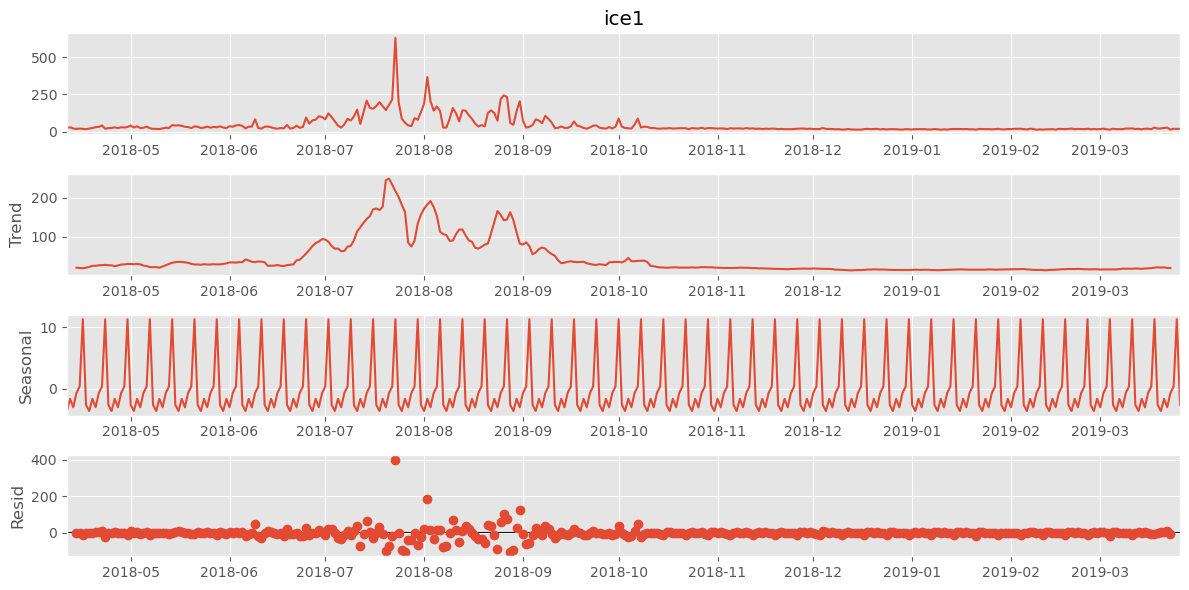

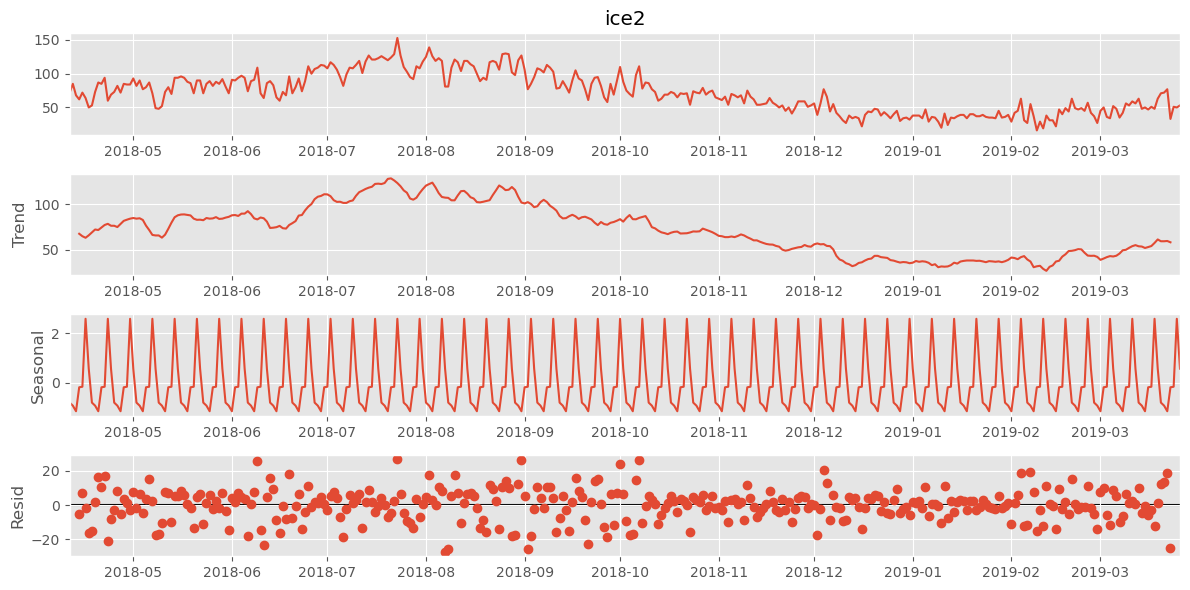

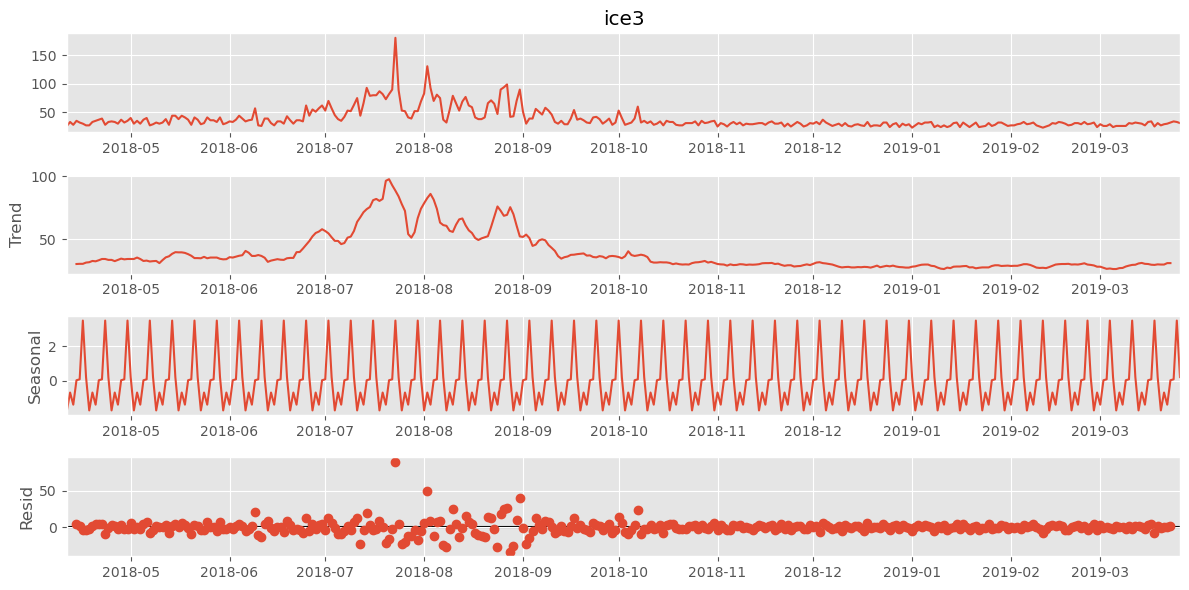

In [5]:
# 1. 加法モデル
for target in ICE_COLS:
    # 成分分解
    train_tmp = train_df.copy()
    result = seasonal_decompose(train_tmp[target], model='additive', period=7)
    result.plot()
    # plt.savefig(f'../work/additive_model_moving_average/{target}.png')
    plt.show()

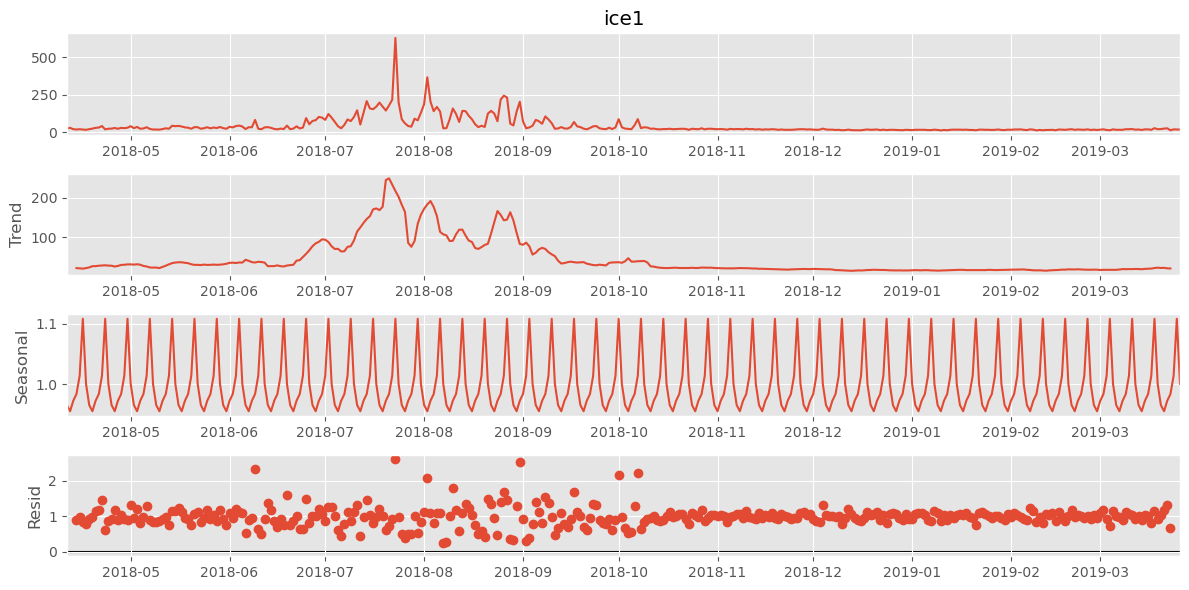

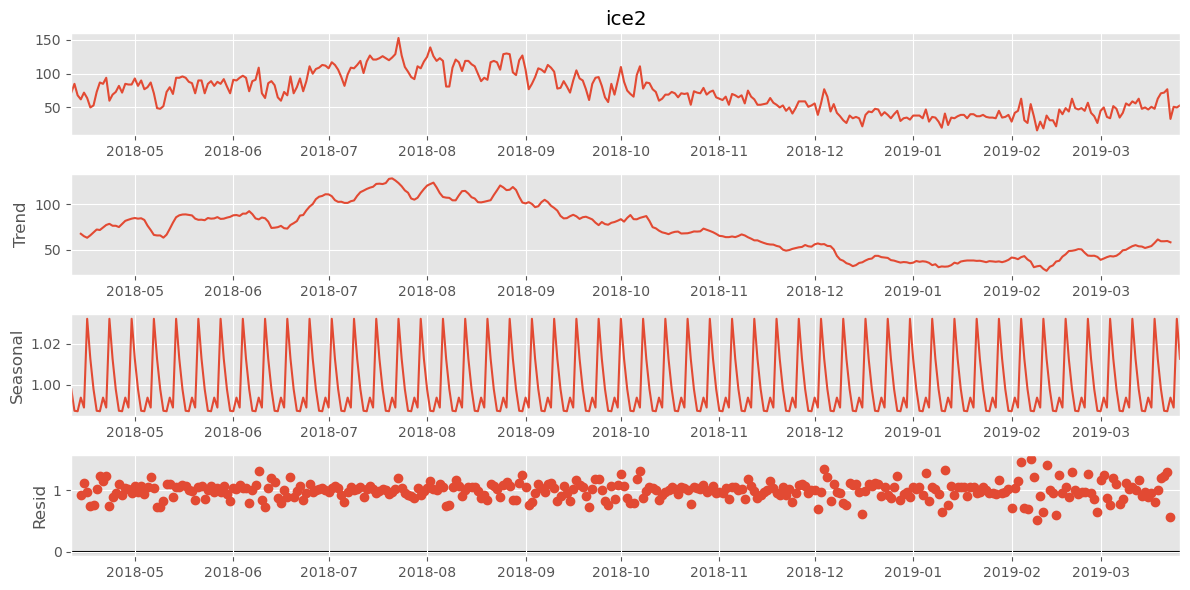

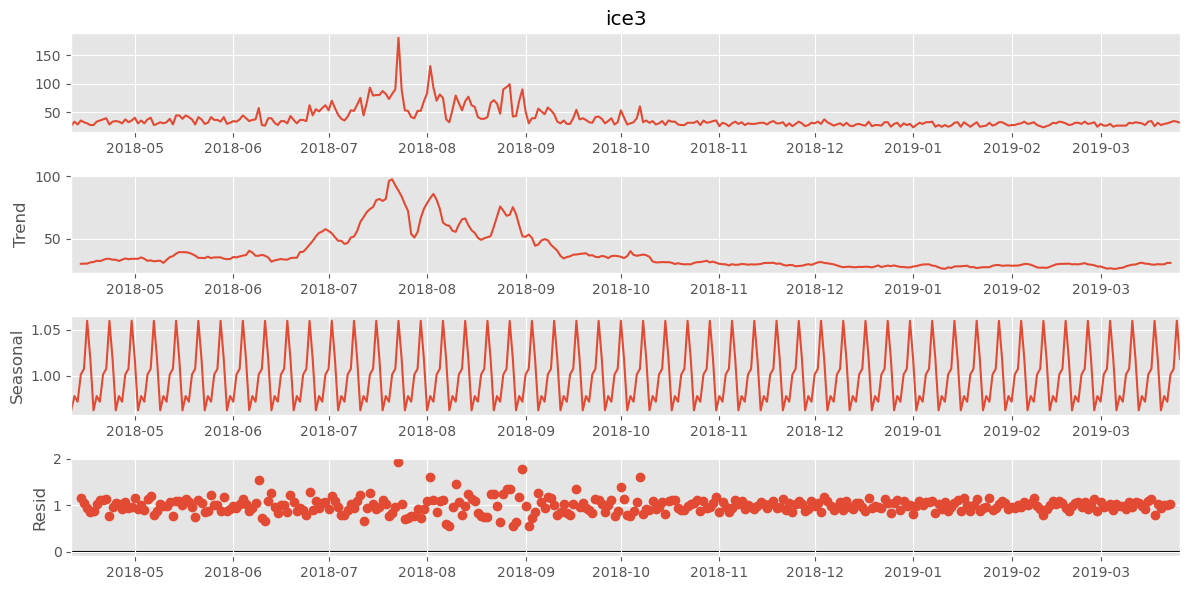

In [6]:
# 2. 乗法モデル
for target in ICE_COLS:
    # 成分分解
    train_tmp = train_df.copy()
    result = seasonal_decompose(train_tmp[target], model='multiplicative', period=7)
    result.plot()
    # plt.savefig(f'../work/multiplicative_model_moving_average/{target}.png')
    plt.show()

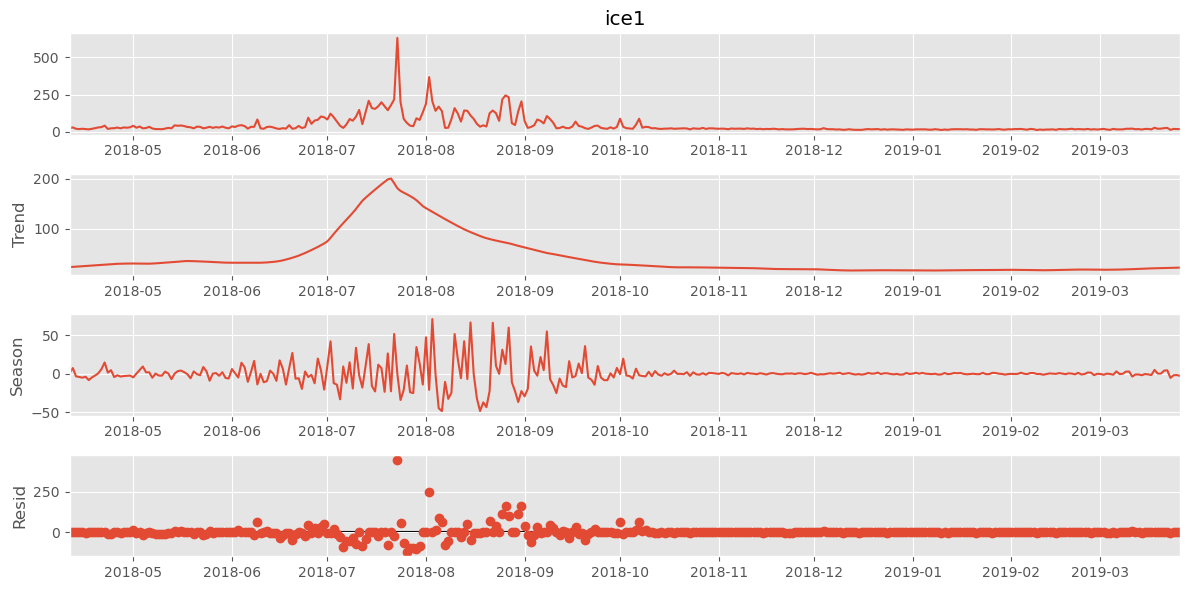

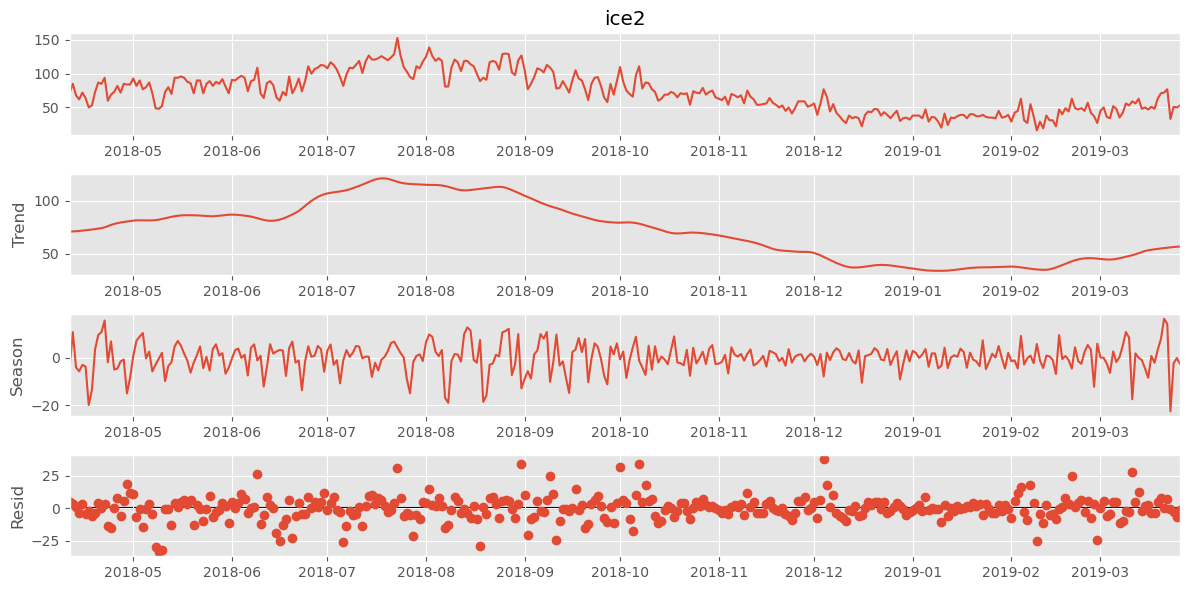

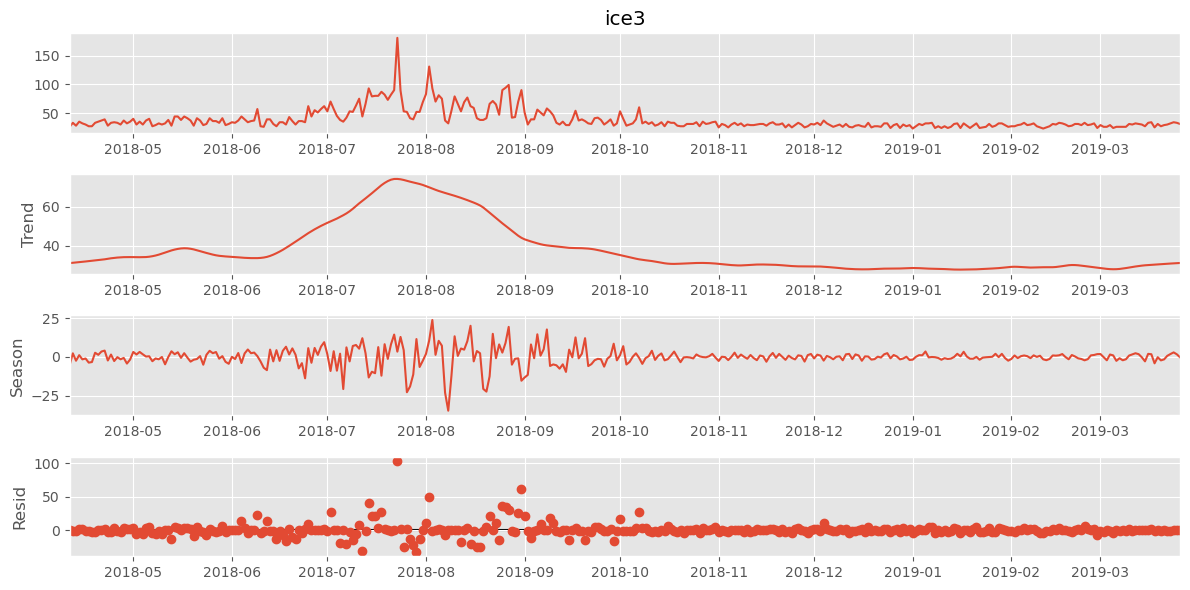

In [7]:
# plot
for target in ICE_COLS:
    # 成分分解
    train_tmp = train_df.copy()
    stl = STL(train_tmp[target], period=12, robust=True).fit()
    stl.plot()
    # plt.savefig(f'../work/stl/{target}.png')
    plt.show()

/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  w

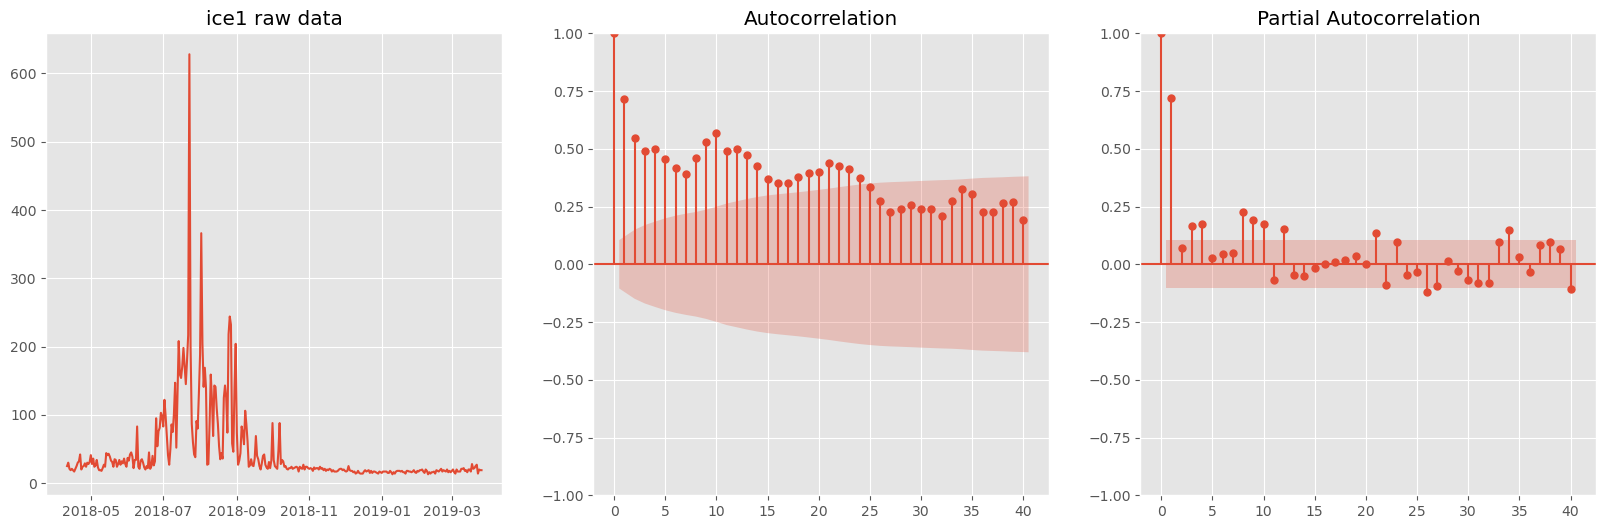

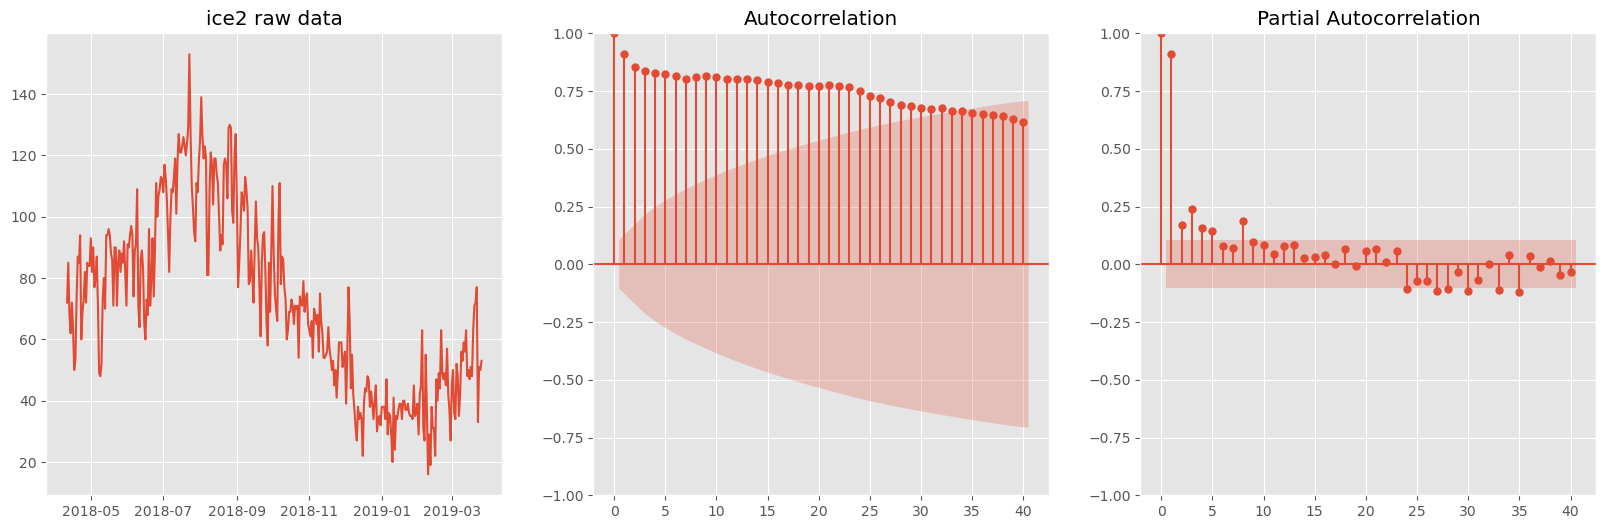

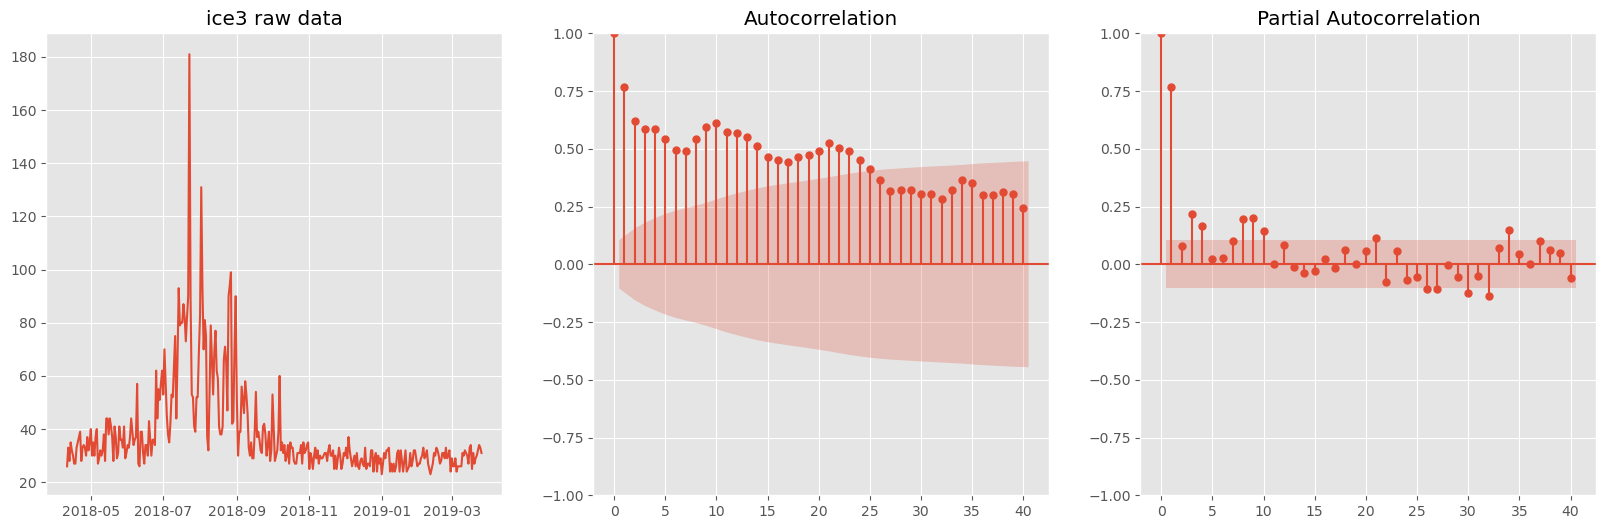

In [8]:
# 原系列に対するPCF, PACF
for target in ICE_COLS:
    train_tmp = train_df.copy()
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    axes = ax.flatten()
    axes[0].plot(train_tmp[target])
    axes[0].set_title(f'{target} raw data')
    fig = sm.graphics.tsa.plot_acf(train_tmp[target], lags=40, ax=axes[1])
    fig = sm.graphics.tsa.plot_pacf(train_tmp[target], lags=40, ax=axes[2])

/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
/home/takafumi/anaconda3/envs/PS_env/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  w

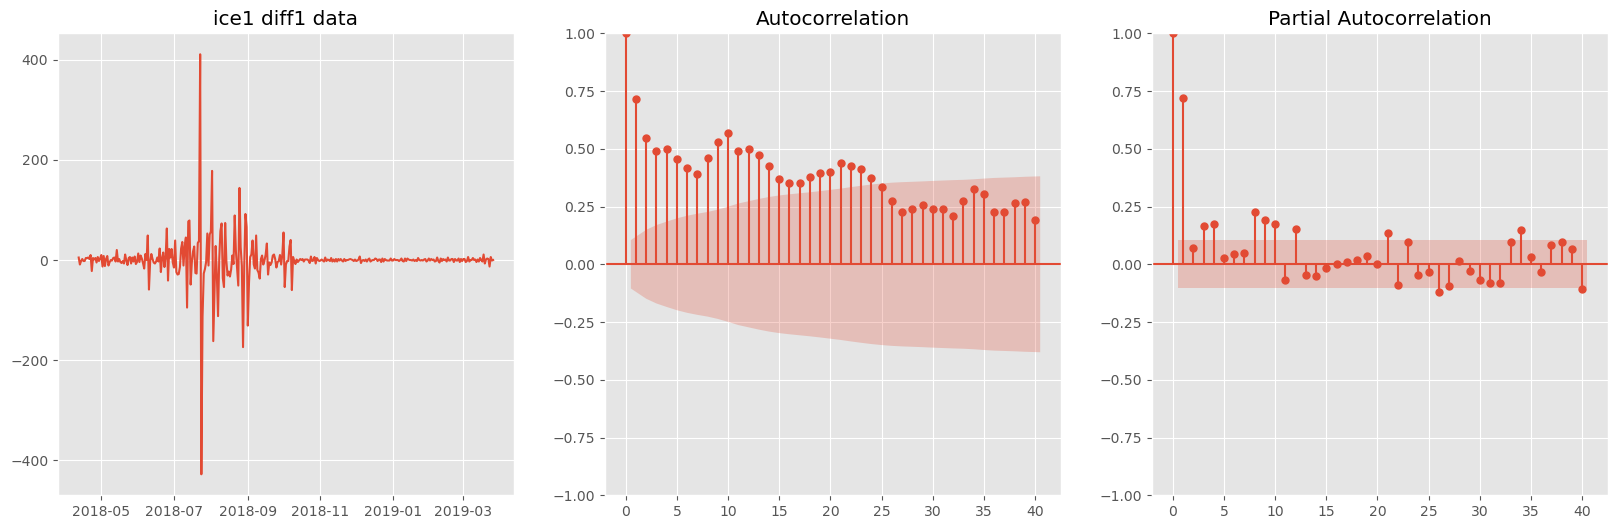

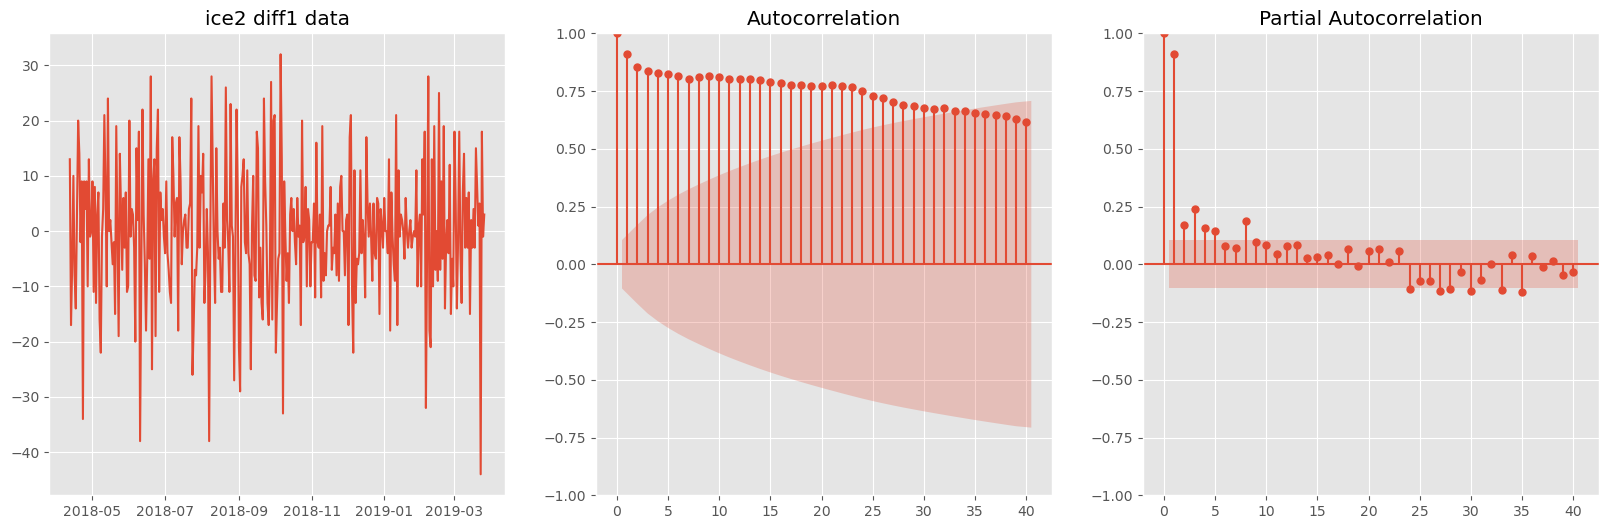

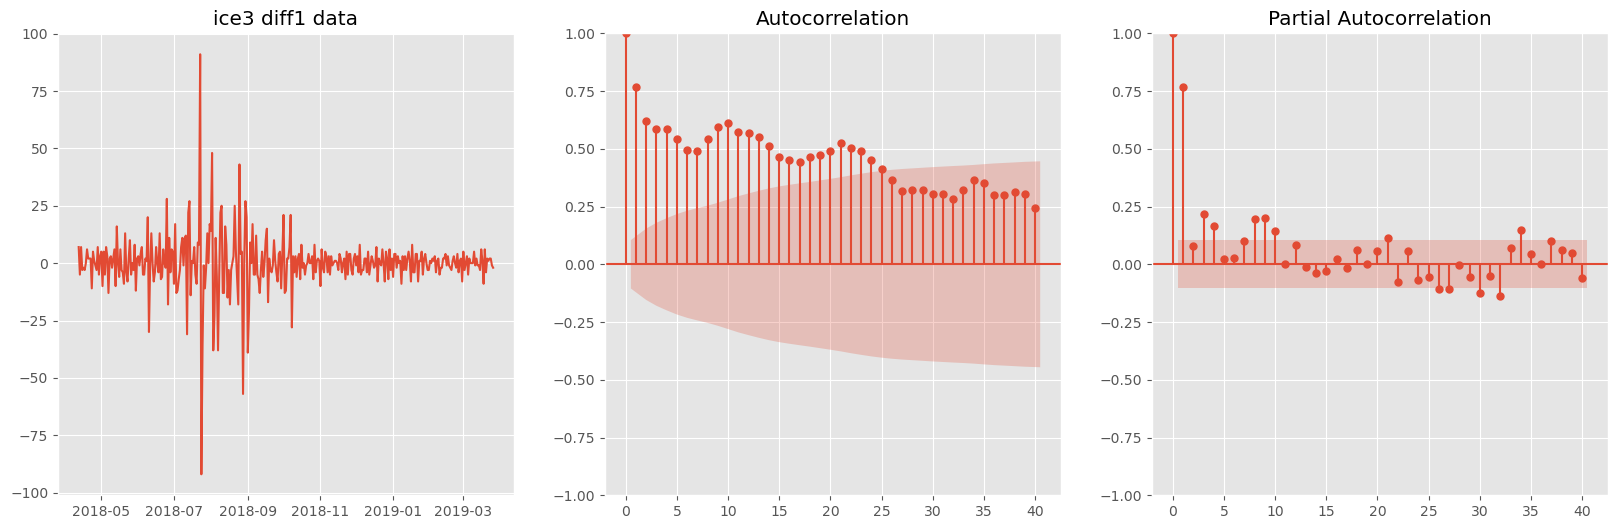

In [9]:
# 1階差分に対するPCF, PACF
for target in ICE_COLS:
    train_tmp = train_df.copy()
    train_tmp['diff1'] = train_tmp.diff(1)[target]
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    axes = ax.flatten()
    axes[0].plot(train_tmp['diff1'])
    axes[0].set_title(f'{target} diff1 data')
    fig = sm.graphics.tsa.plot_acf(train_tmp[target], lags=40, ax=axes[1])
    fig = sm.graphics.tsa.plot_pacf(train_tmp[target], lags=40, ax=axes[2])

### 考察

- ice1, ice3
    - 7, 8, 9月に急に人気になる。
    - STL分解から 7, 8, 9月を除けば定常化しそうな雰囲気がある。
    - AR過程かARMA過程かは分からない
    - 少し周期性がある？

- ice2
    - 7, 8, 9月に穏やかに人気になる。
    - 1階階差ACFが緩やかに減少、PCAFが急に減少 -> AR過程？

- 今後の解析方針
    - 方針①
        - 差分をとり、ARIMA, SARIMAに当てはめられるような次数を探す
    - 方針②
        - 7, 8, 9月を削除し、定常性をADF検定、目視で確かめる(予測が3, 4月であるため、7, 8, 9のデータの影響が少ないと仮定)

## 方針①

差分をとり、ARIMA, SARIMAに当てはめられるような次数を探す

### ADF 検定

In [10]:
# 原系列
results = []

for target in ICE_COLS:
    train_tmp = train_df.copy()
    
    dftest = adfuller(train_tmp[target])
    
    adf_statistics = dftest[0]
    p_value = dftest[1]
    critical_values = [v for v in dftest[4].values()]
    critical_items = [(k, v) for k, v in dftest[4].items()]
        
    result = [adf_statistics, p_value, *critical_values]
    
    eval = '非有意'
    for k, cv in critical_items:
        if adf_statistics < cv:
            eval = f'{k}有意'
            break
    result.append(eval)
    
    results.append(result)
        
adf_df = pd.DataFrame(data=results, index=ICE_COLS, columns=['ADF Statisitcs', 'p-values', '1%', '5%', '10%', 'evalaition'])
adf_df = adf_df.T
display(adf_df)

,ice1,ice2,ice3
ADF Statisitcs,-1.680505,-1.187265,-1.707384
p-values,0.441184,0.67905,0.427312
1%,-3.449846,-3.449673,-3.44973
5%,-2.870129,-2.870053,-2.870079
10%,-2.571346,-2.571306,-2.571319
evalaition,非有意,非有意,非有意


- データ観察の予想通り定常では無い
- またp値より、ice2は単位根過程を持つ可能性が高い

In [11]:
# 1階差分系列
results = []

for target in ICE_COLS:
    train_tmp = train_df.copy()
    train_tmp['diff1'] = train_tmp.diff(1)[target]
    train_tmp.dropna(inplace=True)
        
    dftest = adfuller(train_tmp['diff1'])
    
    adf_statistics = dftest[0]
    p_value = dftest[1]
    critical_values = [v for v in dftest[4].values()]
    critical_items = [(k, v) for k, v in dftest[4].items()]
        
    result = [adf_statistics, p_value, *critical_values]
    
    eval = '非有意'
    for k, cv in critical_items:
        if adf_statistics < cv:
            eval = f'{k}有意'
            break
    result.append(eval)
    
    results.append(result)
        
adf_df = pd.DataFrame(data=results, index=ICE_COLS, columns=['ADF Statisitcs', 'p-values', '1%', '5%', '10%', 'evalaition'])
adf_df = adf_df.T
display(adf_df)

,ice1,ice2,ice3
ADF Statisitcs,-9.775463,-10.164685,-11.572484
p-values,0.0,0.0,0.0
1%,-3.449846,-3.449673,-3.44973
5%,-2.870129,-2.870053,-2.870079
10%,-2.571346,-2.571306,-2.571319
evalaition,1%有意,1%有意,1%有意


- 一回階差系列で1%有意で定常といえる

### 総当たり法でモデル候補探索

考えられる対象データ
- 原系列
- 対数系列

参考
- [リンク 1](https://bigdata-tools.com/arima-sarima-model/#ARIMA)
- [リンク 2](https://blog.brains-tech.co.jp/arima-tutorial-2?hsLang=ja-jp)

#### 1階差分系列

In [13]:
for target in ICE_COLS:
    print(target)
    
    train_tmp = train_df.copy()
    # 最適の次数を決めるため、グリッドサーチを行うための準備
    
    # 各パラメータの範囲を決める
    p = d = q = range(0, 3) #時系列方向のARIMAモデルの次数(p, d, q)検討範囲
    s_p = s_d = s_q = range(0, 2) #周期方向のARIMAモデルの次数(P, D, Q)検討範囲
    
    # p, d, q の組み合わせを表すリストを作成
    pdq = list(itertools.product(p, d, q))
    
    # P, D, Q の組み合わせを表すリストを作成。周期は、1週間、s = 7としている。
    pdq_season = [(*x, 7) for x in list(itertools.product(s_p, s_d, s_q))]
    
    # warnings を表示させないようにする
    warnings.filterwarnings("ignore") 

    # グリッドサーチで、最適の次数をAICで探索
    min_aic = [0, 0, 10000]
    result_params = []
    for param in pdq:
        for param_season in pdq_season:
            try:
                model_sarimax = SARIMAX(train_df[target],
                                        order = param,
                                        seasonal_order=param_season,
                                        enforce_stationarity=True,
                                        enforce_invertibility=True)
    
                results = model_sarimax.fit(disp=False)
                
                # print("order{}, s_order{} - AIC: {}".format(param, param_season, results.aic))
                
                result_params.append((param, param_season, results.aic))
                
                # 最小値を更新
                if results.aic < min_aic[2]:
                    min_aic = [param, param_season, results.aic]
            except:
                continue
    print("\AICが最も良いモデル:", min_aic)
    
    # AICの下位10個を表示
    print('min aics')
    for param in sorted(result_params, key=lambda x: x[2])[:10]:
        print(param)      

ice1
\AICが最も良いモデル: [(2, 2, 2), (1, 0, 0, 7), 39.51364042623398]
min aics
((2, 2, 2), (1, 0, 0, 7), 39.51364042623398)
((2, 1, 2), (1, 1, 1, 7), 3489.7674132450456)
((0, 1, 2), (1, 1, 1, 7), 3489.8592378042085)
((2, 1, 1), (1, 1, 1, 7), 3489.9985289340248)
((1, 1, 2), (1, 1, 1, 7), 3490.4206501670005)
((1, 1, 1), (1, 1, 1, 7), 3492.4087167078296)
((2, 0, 2), (1, 1, 1, 7), 3495.202183659981)
((2, 2, 2), (1, 1, 1, 7), 3496.47858396245)
((2, 0, 1), (1, 1, 1, 7), 3497.2025331623363)
((2, 1, 1), (0, 1, 1, 7), 3497.960220598906)
ice2
\AICが最も良いモデル: [(0, 1, 2), (1, 1, 1, 7), 2648.6114310038756]
min aics
((0, 1, 2), (1, 1, 1, 7), 2648.6114310038756)
((1, 1, 2), (1, 1, 1, 7), 2649.104825334794)
((2, 1, 1), (1, 1, 1, 7), 2649.109067456314)
((1, 1, 1), (1, 1, 1, 7), 2650.6102478332905)
((2, 1, 2), (1, 1, 1, 7), 2651.068428818581)
((1, 1, 2), (0, 1, 1, 7), 2651.704753339399)
((2, 1, 1), (0, 1, 1, 7), 2651.8797174941856)
((1, 2, 2), (1, 1, 1, 7), 2652.197205687723)
((2, 2, 2), (1, 1, 1, 7), 2652.2098